In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import time
import os
import matplotlib.pyplot as plt

## Define a few functions for generating data

In [7]:
def underdamped_position(t_values, amplitude, gamma, Omega, phi):
    """
    Description:
    Calculates the position value of an underdamped harmonic oscillator
    with the inputted t_values and parameters.
    For math, see: https://phys.libretexts.org/Bookshelves/Mathematical_Physics_and_Pedagogy/Complex_Methods_for_the_Sciences_(Chong)/05%3A_Complex_Oscillations/5.03%3A_General_Solution_for_the_Damped_Harmonic_Oscillator

    Inputs:
    t_values: np array or scalar of time values, output has same shape
    amplitude: factor multiplied by entire expression
    gamma: damping coefficient
    Omega: sqrt((angular frequency)**2 - gamma**2). Note that this is 
           capital Omega, not to be confused with lowercase omega 
           (angular frequency). Also note that omega > gamma for 
           underdamped case.
    phi: phase shift

    Output:
    returns np array or scalar of position values, calculated using 
    general solution to underdamped harmonic oscillator (see url in 
    description).

    """
    return amplitude * np.exp(-gamma * t_values) * np.cos(Omega * t_values + phi)

In [8]:
def generate_params():
    """
    Description:
    Generates random values of Omega, gamma, amplitude, and phi that fit
    constraints imposed by underdamped condition.

    Inputs:
    None

    Output:
    returns amplitude, gamma, Omega, phi
    """
    # NOTE these ranges for omega_0 and gamma are somewhat arbitrarily determined
    omega_0 = (1 - 0.1) * np.random.random() + 0.1
    gamma = (0.1 - 0.01) * np.random.random() + 0.01

    amplitude = np.random.random()  # range of 0-1
    phi = np.random.random()  # range of 0-1
    Omega = np.sqrt(omega_0**2 - gamma**2)

    return amplitude, gamma, omega_0, Omega, phi

In [9]:
def generate_independent_data(file_path, file_mode, num_samples, t_start=0, t_stop=100, t_step=1):
    """
    Description:
    Generates a random value of t and random param values, then computes
    the underdamped harmonic oscillator position. Does this num_samples
    times and then writes data to csv.

    Inputs:
    file_path: name of csv to write generated data to
    file_mode: mode to open file_path in
    num_samples: number of random samples to generate (output file will
                 have this many lines +1 for header)
    t_start: beginning value of t range
    t_stop: ending value of t range

    Output:
    returns None, writes data to file
    """
    generated_samples = []
    t_choices = np.arange(t_start, t_stop + t_step, t_step)

    for i in range(num_samples):
        t = np.random.choice(t_choices)
        amplitude, gamma, omega_0, Omega, phi = generate_params()
        position = underdamped_position(t, amplitude, gamma, Omega, phi)
        generated_samples.append([t, Omega, gamma, phi, amplitude, position])

    with open(file_path, file_mode) as fi:
        if (file_mode == "w"):
            fi.write("t,Omega,gamma,phi,amplitude,y\n")

        for sample in generated_samples:
            fi.write(f"{','.join([str(val) for val in sample])}\n")

In [10]:
def generate_range_data(t_start=0, t_stop=100, t_step=0.1):
    """
    Description: generates a set of underdamped harmonic oscillator data
                 using a fixed range of t and random constants.

    Inputs:
    t_start: starting value of t (defaults to 0)
    t_stop: stopping value of t (defaults to 100)
    t_step: number of values from t_start to t_stop (defaults to 1000)

    Output:
    t_values, positions, amplitude, gamma, omega_0, Omega, phi
    """
    # hold range of t values constant across all generated data
    t_values = np.arange(t_start, t_stop + t_step, t_step)

    # randomly generate parameters
    amplitude, gamma, omega_0, Omega, phi = generate_params()

    # analytical solution (y values)
    positions = underdamped_position(t_values, amplitude, gamma, Omega, phi)
    
    return t_values, positions, amplitude, gamma, omega_0, Omega, phi

## Create train dataset

In [16]:
data_dir = "data"
os.system(f"mkdir -p {data_dir}")

train_samples = int(1e6)
train_dataset_name = "underdamped_independent_train"
t_start = 0
t_stop = 50
t_step = 0.1

train_file_path = f"{data_dir}/{train_dataset_name}_samples={train_samples}_t0={t_start}_tf={t_stop}_ts={t_step}.csv"
file_mode = "w"

In [17]:
%%time
generate_independent_data(train_file_path, file_mode, train_samples, t_start=t_start, t_stop=t_stop, t_step=t_step)

CPU times: user 19.7 s, sys: 409 ms, total: 20.1 s
Wall time: 19.9 s


## Create test dataset

In [18]:
test_samples = int(1e4)
test_dataset_name = "underdamped_independent_test"

test_file_path = f"{data_dir}/{test_dataset_name}_samples={test_samples}_t0={t_start}_tf={t_stop}_ts={t_step}.csv"
file_mode = "w"

In [19]:
%%time
generate_independent_data(test_file_path, file_mode, test_samples, t_start=t_start, t_stop=t_stop, t_step=t_step)

CPU times: user 278 ms, sys: 20.5 ms, total: 298 ms
Wall time: 286 ms


## Load and prepare train/test datasets

In [30]:
# train
train_df = pd.read_csv(train_file_path)
feat_cols = [col for col in train_df.columns if col != "y"]
X_train = torch.tensor(train_df[feat_cols].values).float()
y_train = torch.tensor(train_df["y"].values).float()
y_train = y_train.reshape(y_train.shape[0], 1)

# test
test_df = pd.read_csv(test_file_path)
X_test = torch.tensor(test_df[feat_cols].values).float()
y_test = torch.tensor(test_df["y"].values).float()
y_test = y_test.reshape(y_test.shape[0], 1)

## Define neural net class

In [21]:
class FeedFwdNN(nn.Module):
    def __init__(self, input_size, output_size, optim_lr=0.0001):
        # torch inheritance thing
        super(FeedFwdNN, self).__init__()

        # the network 
        self.dense1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.dense2 = nn.Linear(64, 64)
        self.relu2 = nn.ReLU()
        self.dense3 = nn.Linear(64, 64)
        self.relu3 = nn.ReLU()
        self.dense4 = nn.Linear(64, 64)
        self.relu4 = nn.ReLU()
        self.out_dense = nn.Linear(64, output_size)
        
        # optimizer and loss
        self.optimizer = optim.Adam(self.parameters(), lr=optim_lr)
        self.criteria = nn.MSELoss()
        self.loss = None
    
    def forward(self, input_data):
        """
        Description:
        Forward pass of the neural network.

        Inputs:
        input_data: tensor of a single sample of data

        Ouput:
        returns tensor of network's final output
        """
        x = self.dense1(input_data)
        x = self.relu1(x)
        x = self.dense2(x)
        x = self.relu2(x)
        x = self.dense3(x)
        x = self.relu3(x)
        x = self.dense4(x)
        x = self.relu4(x)
        x = self.out_dense(x)
        return x
    
    def backward(self, outputs, targets):
        """
        Description:
        Backward pass of the neural network. Loss computed, optimizer
        zeroed, loss and optimizer complete backward step.

        Inputs:
        outputs: tensor of network's predicted outputs of a given sample
                 (i.e. output of forward pass)
        targets: actual output tensor for given sample

        Output:
        returns loss value between outputs and targets
        """
        self.loss = self.criteria(outputs, targets)
        loss_copy = self.loss
        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()
        return loss_copy
    
    def compute_loss(self, outputs, targets):
        """
        Description:
        Computes loss without actually backpropagating. Used for checking
        network's progress with test data.

        Inputs:
        outputs: tensor of network's predicted outputs of a given sample
                 (i.e. output of forward pass)
        targets: actual output tensor for given sample

        Output:
        returns loss value between outputs and targets
        """
        return self.criteria(outputs, targets)
    
    def fit(self, )

## Initialize nn

In [23]:
model_dir = "models"
model_path = f"{model_dir}/{train_file_path.replace('data/', '').replace('train_', '').replace('.csv', '.pt')}"
input_len = X_train.shape[1]
num_outputs = 1  # nn predicts a scalar

In [10]:
model = FeedFwdNN(input_len, num_outputs)

## Training loop

In [11]:
# parameters of training loop
num_epochs = 30
batch_size = 64
batches = torch.arange(0, X_train.shape[0], batch_size)
train_losses = []  
test_losses = []

for epoch_idx in range(num_epochs):
    start = time.time()
    print(f"epoch: {epoch_idx}")

    for batch in batches:
        X_batch = X_train[batch:batch + batch_size]
        y_batch = y_train[batch:batch + batch_size]
        y_predictions = model.forward(X_batch)
        train_loss = model.backward(y_predictions, y_batch)

    y_test_predictions = model.forward(X_test)
    test_loss = model.compute_loss(y_test_predictions, y_test)
    train_losses.append(train_loss.detach().numpy())
    test_losses.append(test_loss.detach().numpy())
    print(f"train loss = {train_loss}, test loss = {test_loss}, time = {time.time() - start:.2f} seconds\n")

# save model
os.system(f"rm -rf {model_path}")  
torch.save(model.state_dict(), model_path)

epoch: 0
train loss = 0.01494506374001503, test loss = 0.012129643000662327, time = 13.57 seconds

epoch: 1
train loss = 0.010408704169094563, test loss = 0.008917510509490967, time = 13.91 seconds

epoch: 2
train loss = 0.009275947697460651, test loss = 0.006940765306353569, time = 13.91 seconds

epoch: 3
train loss = 0.008704660460352898, test loss = 0.006634185090661049, time = 14.14 seconds

epoch: 4
train loss = 0.006913329474627972, test loss = 0.0050155241042375565, time = 14.90 seconds

epoch: 5
train loss = 0.005316952243447304, test loss = 0.004177853465080261, time = 15.03 seconds

epoch: 6
train loss = 0.0043426440097391605, test loss = 0.00312502752058208, time = 15.23 seconds

epoch: 7
train loss = 0.0029560362454503775, test loss = 0.0028234354685992002, time = 15.45 seconds

epoch: 8
train loss = 0.0024858831893652678, test loss = 0.002651401562616229, time = 15.44 seconds

epoch: 9
train loss = 0.0024992446415126324, test loss = 0.002521610353142023, time = 15.67 secon

In [62]:
plt.rcParams["figure.figsize"] = (13, 8)
plt.rcParams["font.size"] = 16

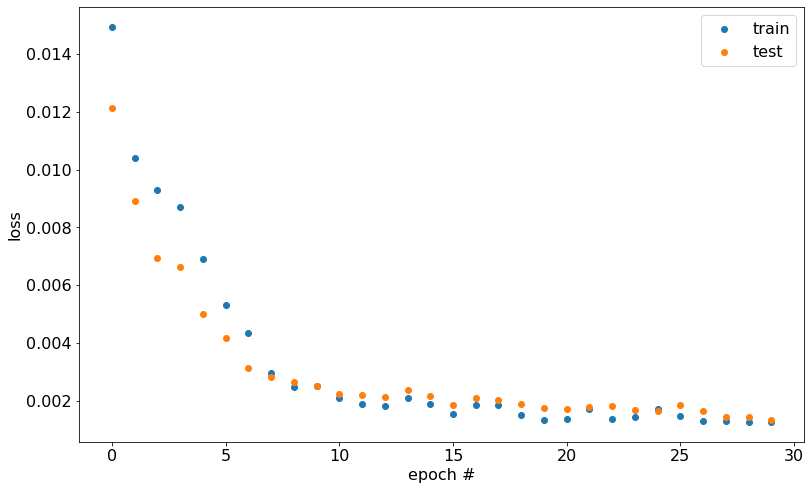

In [13]:
# plot losses
epoch_indexes = [i for i in range(num_epochs)]
plt.scatter(epoch_indexes, train_losses, label="train")
plt.scatter(epoch_indexes, test_losses, label="test")
plt.legend()
plt.xlabel("epoch #")
plt.ylabel("loss")
plt.show()

In [26]:
# do this if you come back and dont train a new model above
load_model = True

if load_model:
    model = FeedFwdNN(len(feat_cols), 1)
    model.load_state_dict(torch.load(model_path))

## Create data over an interval of t

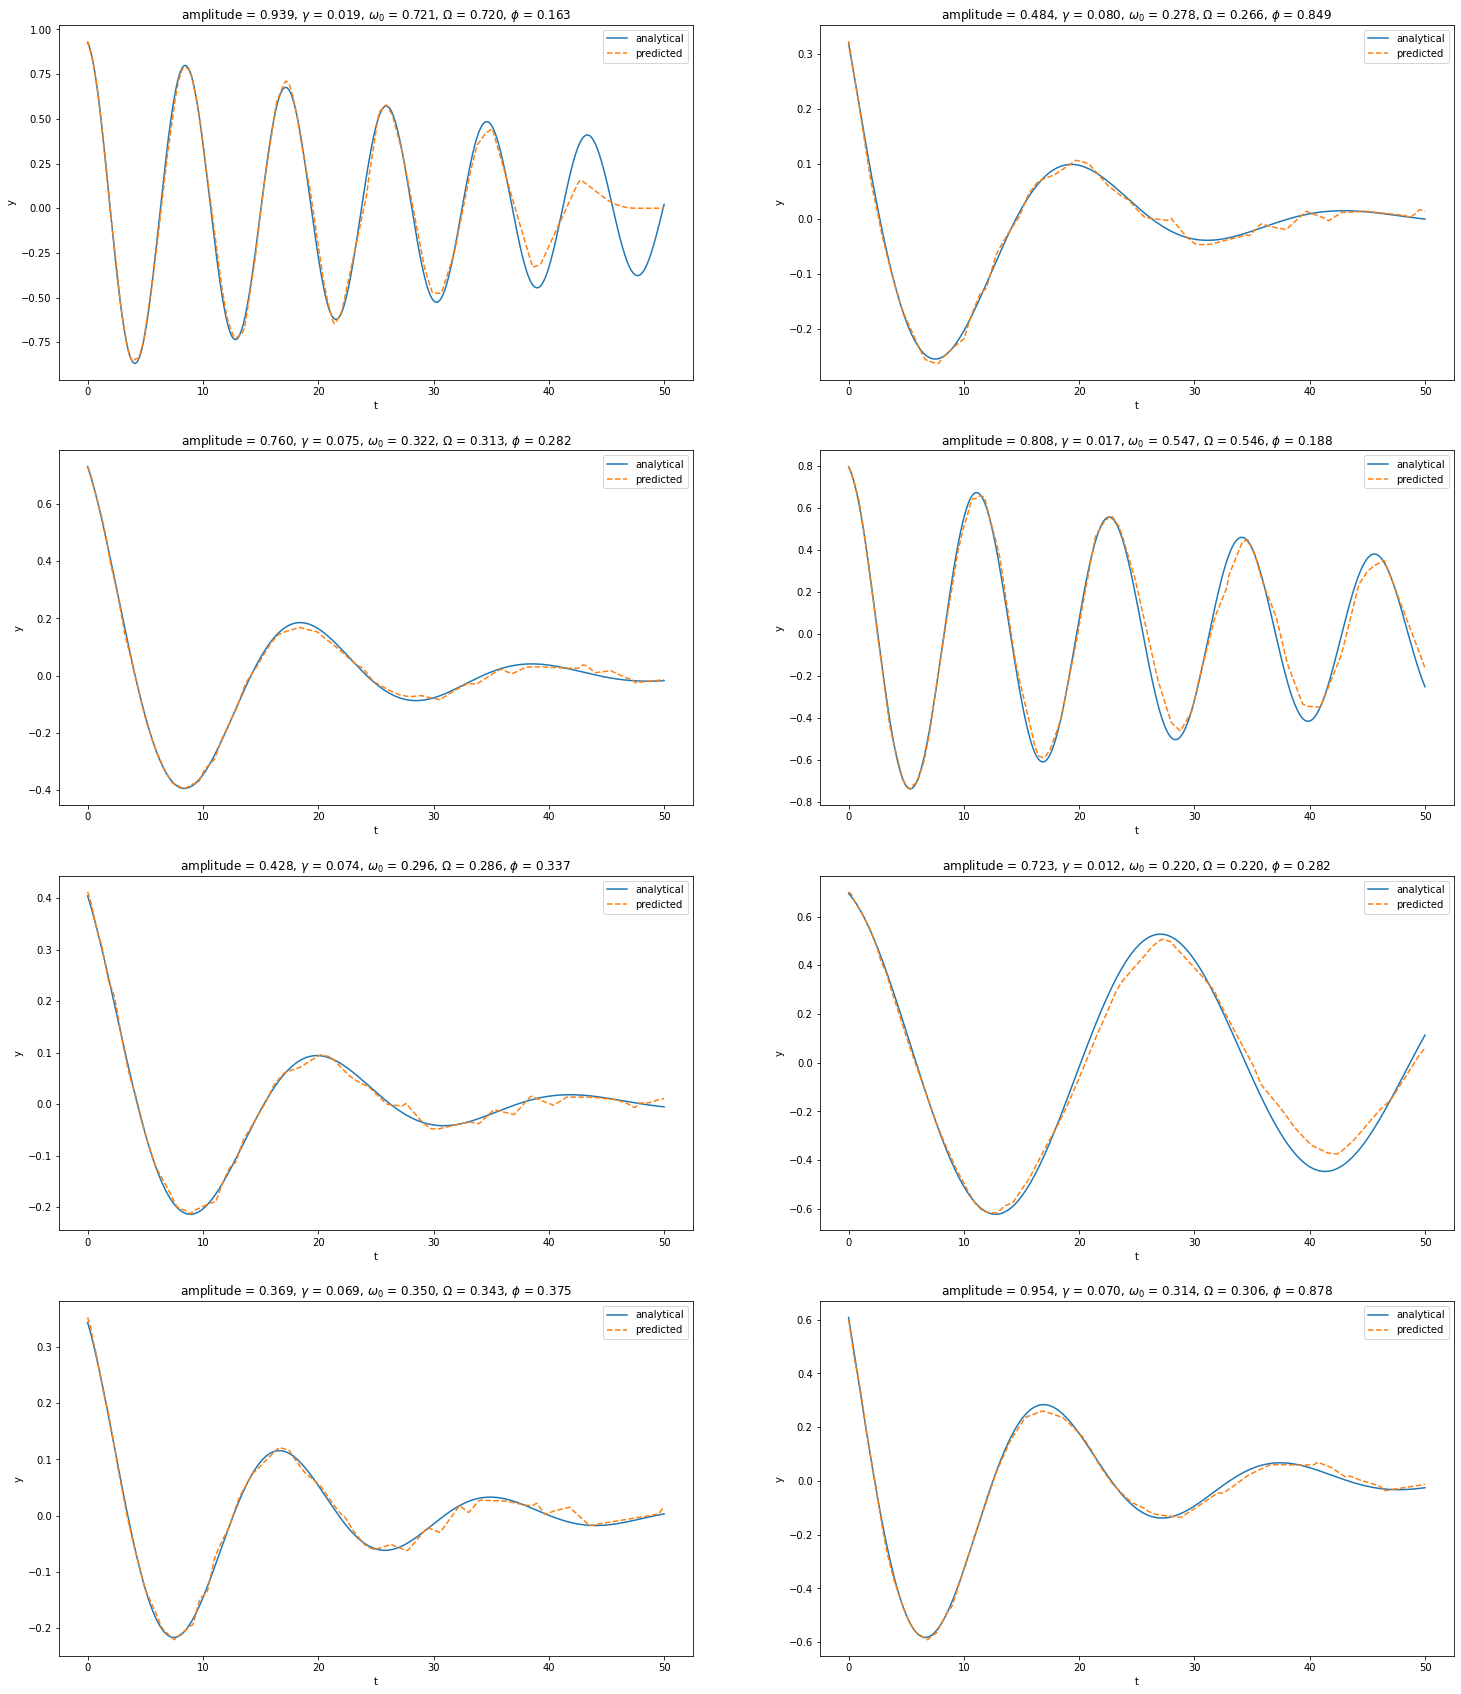

In [27]:
num_rows = 4
num_cols = 2
num_datasets = num_rows * num_cols
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(25, 30))
row_idx = 0
col_idx = 0

for _ in range(num_datasets):
    # create data from t_start to t_stop in t_step increments
    t_values, positions, amplitude, gamma, omega_0, Omega, phi = generate_range_data(t_start=t_start, t_stop=t_stop, t_step=t_step)
    
    # there's probably a more efficient way than this, but this makes getting the correct shapes for
    # model simple below
    validation_df = pd.DataFrame({"t": t_values, "amplitude": amplitude, "gamma": gamma, "omega_0": omega_0, "Omega": Omega, "phi": phi, "y": positions})
    
    # make predictions over this new range of data
    X_val = torch.tensor(validation_df[feat_cols].values).float()
    y_val = validation_df["y"].to_numpy()
    val_preds = model(X_val)
    val_preds = val_preds.detach().numpy()
    val_preds = val_preds.reshape(val_preds.shape[0])

    ax[row_idx, col_idx].plot(validation_df["t"], y_val, label="analytical")
    ax[row_idx, col_idx].plot(validation_df["t"], val_preds, "--", label="predicted")
    ax[row_idx, col_idx].set_xlabel("t")
    ax[row_idx, col_idx].set_ylabel("y")
    ax[row_idx, col_idx].legend()
    ax[row_idx, col_idx].set_title(fr"amplitude = {amplitude:.3f}, $\gamma$ = {gamma:.3f}, $\omega_0$ = {omega_0:.3f}, $\Omega$ = {Omega:.3f}, $\phi$ = {phi:.3f}")
    
    col_idx += 1
    if (col_idx == num_cols):
        col_idx = 0
        row_idx += 1

## Feature importance analysis

In [67]:
# permutation importance for fitted model

test_preds = model(X_test)
test_loss = model.compute_loss(test_preds, y_test).detach().numpy()
feat_importance_mags = {feat: 0 for feat in feat_cols}

# implementation of feature permutation importance algorithm
# https://scikit-learn.org/stable/modules/permutation_importance.html
for col_idx in range(X_test.shape[1]):
    X_copy = X_test.detach().clone()

    # shuffle values in column
    np.random.shuffle(X_copy.numpy()[:, col_idx])
    
    # make predictions, find diff in MSE loss for each shuffled feature
    corrupted_preds = model(X_copy)
    corrupted_loss = model.compute_loss(corrupted_preds, y_test).detach().numpy()
    feat_importance = test_loss - corrupted_loss 
    feat_name = feat_cols[col_idx]
    feat_importance_mags[feat_name] = abs(feat_importance)

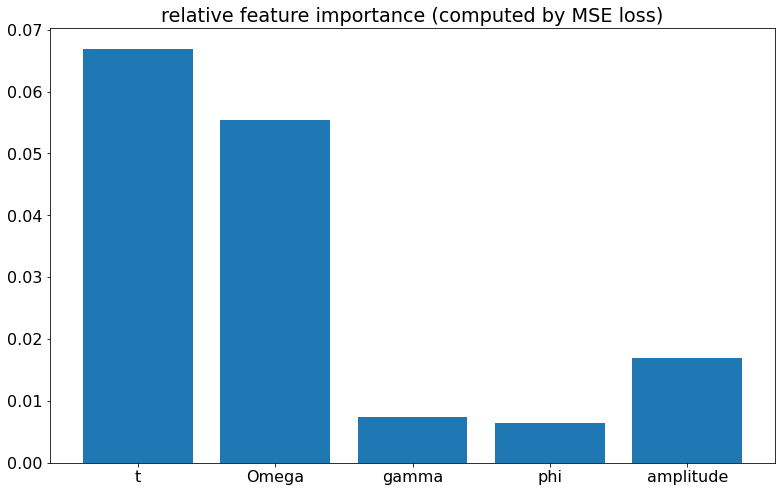

In [69]:
# relative importance of each of these is about what you'd expect from a physics perspective
plt.bar([k for k in feat_importance_mags], [val for k, val in feat_importance_mags.items()])
plt.title("relative feature importance (computed by MSE loss)")
plt.show()

## Edge cases

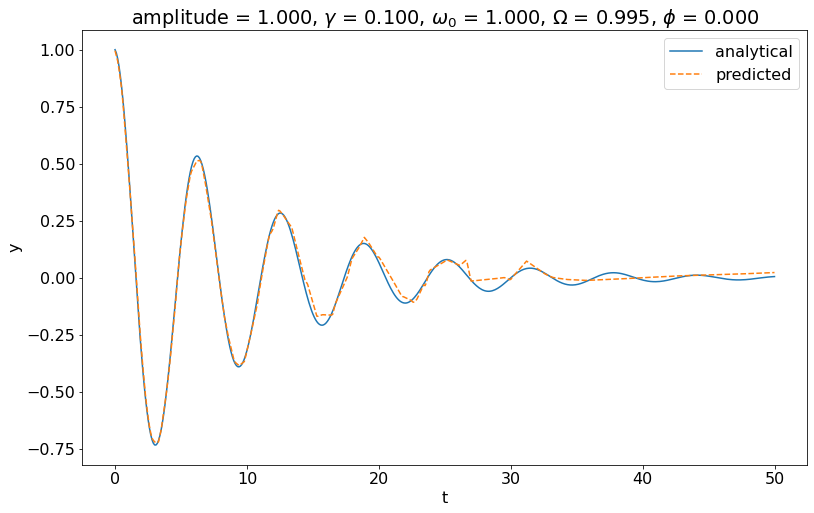

In [95]:
# large omega_0, large gamma
amplitude = 1
omega_0 = 1
gamma = 0.1
Omega = np.sqrt(omega_0**2 - gamma**2)
phi = 0
positions = underdamped_position(t_values, amplitude, gamma, Omega, phi)

sample_df = pd.DataFrame({"t": t_values, "amplitude": amplitude, "gamma": gamma, "omega_0": omega_0, "Omega": Omega, "phi": phi, "y": positions})
X_sample = torch.tensor(sample_df[feat_cols].values).float()
y_sample = sample_df["y"].to_numpy()
sample_preds = model(X_sample)
sample_preds = sample_preds.detach().numpy()
sample_preds = sample_preds.reshape(sample_preds.shape[0])
plt.plot(sample_df["t"], y_sample, label="analytical")
plt.plot(sample_df["t"], sample_preds, "--", label="predicted")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.title(fr"amplitude = {amplitude:.3f}, $\gamma$ = {gamma:.3f}, $\omega_0$ = {omega_0:.3f}, $\Omega$ = {Omega:.3f}, $\phi$ = {phi:.3f}")
plt.show()

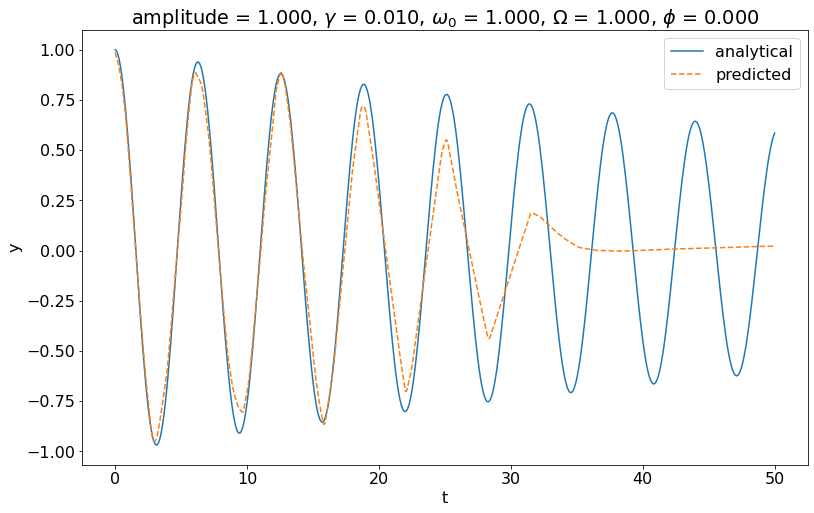

In [96]:
# large omega_0, small gamma
amplitude = 1
omega_0 = 1
gamma = 0.01
Omega = np.sqrt(omega_0**2 - gamma**2)
phi = 0
positions = underdamped_position(t_values, amplitude, gamma, Omega, phi)

sample_df = pd.DataFrame({"t": t_values, "amplitude": amplitude, "gamma": gamma, "omega_0": omega_0, "Omega": Omega, "phi": phi, "y": positions})
X_sample = torch.tensor(sample_df[feat_cols].values).float()
y_sample = sample_df["y"].to_numpy()
sample_preds = model(X_sample)
sample_preds = sample_preds.detach().numpy()
sample_preds = sample_preds.reshape(sample_preds.shape[0])
plt.plot(sample_df["t"], y_sample, label="analytical")
plt.plot(sample_df["t"], sample_preds, "--", label="predicted")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.title(fr"amplitude = {amplitude:.3f}, $\gamma$ = {gamma:.3f}, $\omega_0$ = {omega_0:.3f}, $\Omega$ = {Omega:.3f}, $\phi$ = {phi:.3f}")
plt.show()

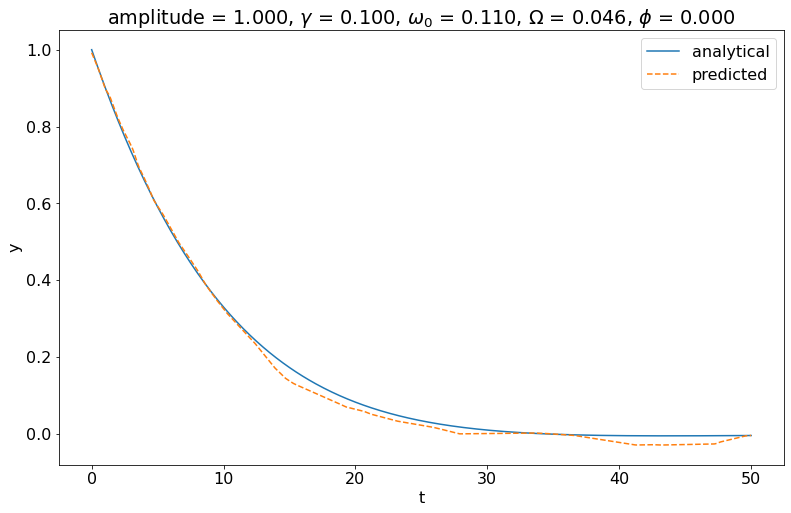

In [97]:
# small omega_0, large gamma
amplitude = 1
omega_0 = 0.11
gamma = 0.1
Omega = np.sqrt(omega_0**2 - gamma**2)
phi = 0
positions = underdamped_position(t_values, amplitude, gamma, Omega, phi)

sample_df = pd.DataFrame({"t": t_values, "amplitude": amplitude, "gamma": gamma, "omega_0": omega_0, "Omega": Omega, "phi": phi, "y": positions})
X_sample = torch.tensor(sample_df[feat_cols].values).float()
y_sample = sample_df["y"].to_numpy()
sample_preds = model(X_sample)
sample_preds = sample_preds.detach().numpy()
sample_preds = sample_preds.reshape(sample_preds.shape[0])
plt.plot(sample_df["t"], y_sample, label="analytical")
plt.plot(sample_df["t"], sample_preds, "--", label="predicted")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.title(fr"amplitude = {amplitude:.3f}, $\gamma$ = {gamma:.3f}, $\omega_0$ = {omega_0:.3f}, $\Omega$ = {Omega:.3f}, $\phi$ = {phi:.3f}")
plt.show()

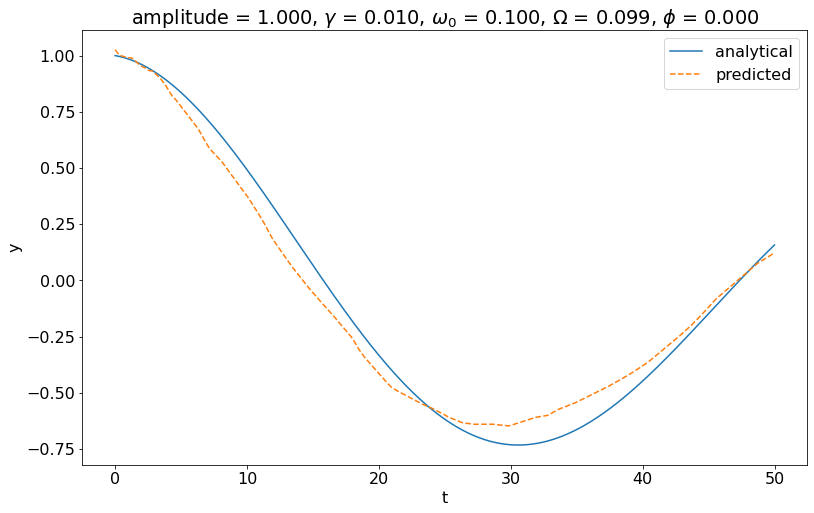

In [99]:
# small omega_0, small gamma
amplitude = 1
omega_0 = 0.1
gamma = 0.01
Omega = np.sqrt(omega_0**2 - gamma**2)
phi = 0
positions = underdamped_position(t_values, amplitude, gamma, Omega, phi)

sample_df = pd.DataFrame({"t": t_values, "amplitude": amplitude, "gamma": gamma, "omega_0": omega_0, "Omega": Omega, "phi": phi, "y": positions})
X_sample = torch.tensor(sample_df[feat_cols].values).float()
y_sample = sample_df["y"].to_numpy()
sample_preds = model(X_sample)
sample_preds = sample_preds.detach().numpy()
sample_preds = sample_preds.reshape(sample_preds.shape[0])
plt.plot(sample_df["t"], y_sample, label="analytical")
plt.plot(sample_df["t"], sample_preds, "--", label="predicted")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.title(fr"amplitude = {amplitude:.3f}, $\gamma$ = {gamma:.3f}, $\omega_0$ = {omega_0:.3f}, $\Omega$ = {Omega:.3f}, $\phi$ = {phi:.3f}")
plt.show()